In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import iris
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import numpy as np
from scipy.stats import norm
import xarray as xr

In [2]:
pg_path = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-db150/init_test/db150a.pg19880901.pp')

In [3]:
cubes = iris.load(pg_path)

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/fileformats/pp.py:1563: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t1 = cftime.datetime(
/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/fileformats/pp.py:1598: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t2 = cftime.datetime(
/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/cf_units/__init__.py:411: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  dates = np.array([dt and dt.replace(microsecond=0) for dt in dates])
/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/fileformats/rules.py:353: UserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(msg.format(factory=factory_name))


In [4]:
spt_pattern = cubes.extract_cube(iris.AttributeConstraint(STASH='m01s35i23'))

In [5]:
spt_pattern

<iris 'Cube' of m01s35i023 / (unknown) (time: 60; model_level_number: 85; latitude: 144; longitude: 192)>

In [6]:
spt_pattern = xr.DataArray.from_iris(spt_pattern)

In [7]:
spt_pattern

<xarray.DataArray 'filled-0c8ea5fd89b8b954331896639a310c3f' (time: 60,
                                                             model_level_number: 85,
                                                             latitude: 144,
                                                             longitude: 192)>
dask.array<filled, shape=(60, 85, 144, 192), dtype=float32, chunksize=(1, 1, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) object 1988-09-02 00:00:00 ... 1988-11-01...
  * model_level_number       (model_level_number) int32 1 2 3 4 ... 82 83 84 85
  * latitude                 (latitude) float32 -89.38 -88.12 ... 88.12 89.38
  * longitude                (longitude) float32 0.9375 2.812 ... 357.2 359.1
    forecast_reference_time  object ...
    forecast_period          (time) timedelta64[ns] ...
    level_height             (model_level_number) float32 ...
    sigma                    (model_level_number) float32 ...
Attributes:
    source:      Data from Met Office Unified Model
    um_version:  13.0
    STASH:       m01s35i023

In [8]:
spt_pattern.level_height.data[26]  # ~5km

5036.6665

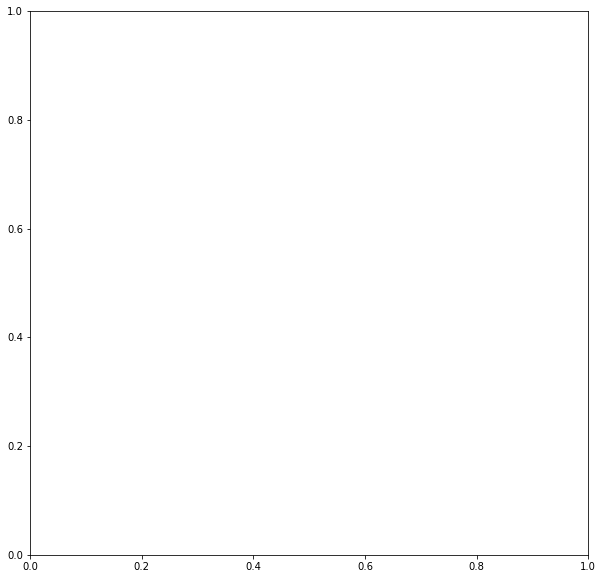

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))

In [10]:
spt_pattern.isel(time=0)

<xarray.DataArray 'filled-0c8ea5fd89b8b954331896639a310c3f' (
                                                             model_level_number: 85,
                                                             latitude: 144,
                                                             longitude: 192)>
dask.array<getitem, shape=(85, 144, 192), dtype=float32, chunksize=(1, 144, 192), chunktype=numpy.ndarray>
Coordinates:
    time                     object 1988-09-02 00:00:00
  * model_level_number       (model_level_number) int32 1 2 3 4 ... 82 83 84 85
  * latitude                 (latitude) float32 -89.38 -88.12 ... 88.12 89.38
  * longitude                (longitude) float32 0.9375 2.812 ... 357.2 359.1
    forecast_reference_time  object ...
    forecast_period          timedelta64[ns] ...
    level_height             (model_level_number) float32 ...
    sigma                    (model_level_number) float32 ...
Attributes:
    source:      Data from Met Office Unified Model
    um_version:  13.0
    STASH:       m01s35i023

In [11]:
from cartopy.util import add_cyclic_point
import xarray as xr 

def xr_add_cyclic_point(da):
    """
    Inputs
    da: xr.DataArray with dimensions (time,lat,lon)
    """

    # Use add_cyclic_point to interpolate input data
    lon_idx = da.dims.index('longitude')
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.longitude, axis=lon_idx)

    # Generate output DataArray with new data but same structure as input
    outp_da = xr.DataArray(data=wrap_data, 
                           coords = {'time': da.time, 'latitude': da.latitude, 'longitude': wrap_lon}, 
                           dims=da.dims, 
                           attrs=da.attrs)
    
    return outp_da

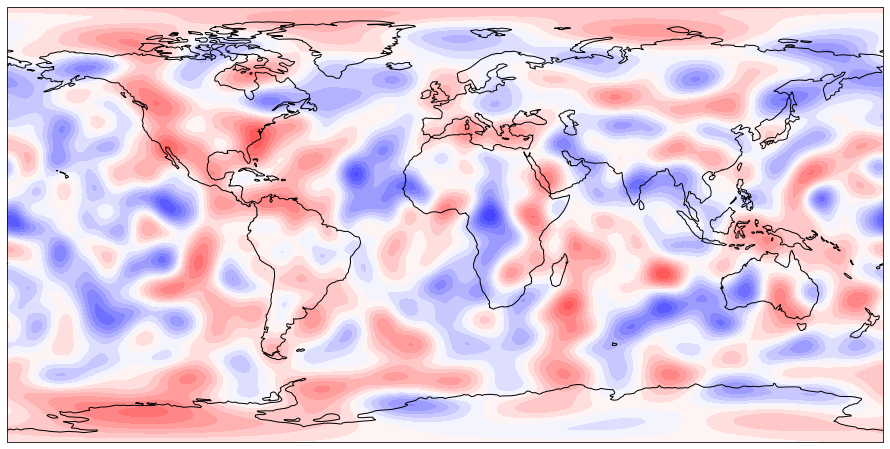

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((18, 8))
ax.coastlines()
d = xr_add_cyclic_point(spt_pattern.isel(time=15))
ax.contourf(d.longitude, d.latitude, d[15], vmin=-1.17, vmax=1.17, cmap='bwr', levels=20)


In [13]:
d = spt_pattern.isel(time=15)
def plot_anim_frame_z(idx):
    # print(idx)
    ax.clear()
    h = d[idx].level_height.values.item()
    ax.set_title(f'{idx}: {h:.1f}m')
    ax.imshow(d[idx], vmin=-1.17, vmax=1.17, cmap='bwr')
    # plt.colorbar()


anim = matplotlib.animation.FuncAnimation(fig, plot_anim_frame_z, frames=range(85), interval=100)
anim

In [14]:
d[1].level_height.values.item()

36.66667175292969

In [15]:


d = spt_pattern.isel(model_level_number=26)
def plot_anim_frame_t(idx):
    # print(idx)
    ax.clear()
    t = d[idx].time.values.item()
    ax.set_title(f'{idx}: {t}m')
    im = ax.imshow(d[idx], vmin=-1.17, vmax=1.17, cmap='bwr')
    # plt.colorbar(im, ax=ax)
    clear_output(wait=True)

anim = matplotlib.animation.FuncAnimation(fig, plot_anim_frame_t, frames=range(30), interval=100)
anim

In [16]:
d[0].time.values.item()

cftime.Datetime360Day(1988, 9, 2, 0, 0, 0, 0, has_year_zero=True)

-1.1616211 1.1652832


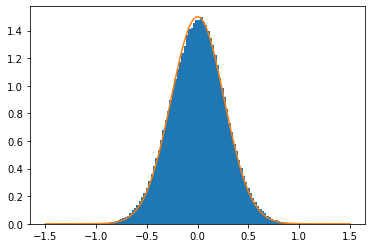

In [17]:
d = spt_pattern.isel(model_level_number=26)
vals = d.values.flatten()
print(vals.min(), vals.max())
plt.hist(vals, bins=100, density=True)
x = np.linspace(-1.5, 1.5, 1001)
plt.plot(x, 1.5 * np.exp(-(x * np.exp(1))**2)) # fitted by hand.

-1.4172363 1.260498


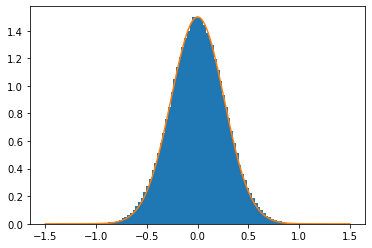

In [18]:
d = spt_pattern.isel(model_level_number=10)
vals = d.values.flatten()
print(vals.min(), vals.max())
plt.hist(vals, bins=100, density=True)
x = np.linspace(-1.5, 1.5, 1001)
plt.plot(x, 1.5 * np.exp(-(x * np.exp(1))**2)) # fitted by hand.

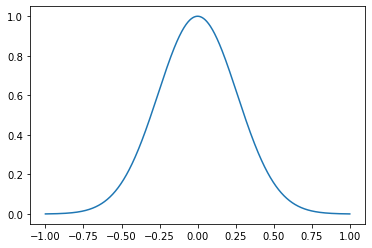

In [19]:
x = np.linspace(-1, 1, 1001)
plt.plot(x, np.exp(-(x * np.exp(1))**2))

In [20]:
d = spt_pattern.isel(time=15)


In [21]:
d

<xarray.DataArray 'filled-0c8ea5fd89b8b954331896639a310c3f' (
                                                             model_level_number: 85,
                                                             latitude: 144,
                                                             longitude: 192)>
dask.array<getitem, shape=(85, 144, 192), dtype=float32, chunksize=(1, 144, 192), chunktype=numpy.ndarray>
Coordinates:
    time                     object 1988-09-17 00:00:00
  * model_level_number       (model_level_number) int32 1 2 3 4 ... 82 83 84 85
  * latitude                 (latitude) float32 -89.38 -88.12 ... 88.12 89.38
  * longitude                (longitude) float32 0.9375 2.812 ... 357.2 359.1
    forecast_reference_time  object ...
    forecast_period          timedelta64[ns] ...
    level_height             (model_level_number) float32 ...
    sigma                    (model_level_number) float32 ...
Attributes:
    source:      Data from Met Office Unified Model
    um_version:  13.0
    STASH:       m01s35i023

In [22]:
d2 = d.sel(latitude=50, method='nearest')

In [23]:
d2

<xarray.DataArray 'filled-0c8ea5fd89b8b954331896639a310c3f' (
                                                             model_level_number: 85,
                                                             longitude: 192)>
dask.array<getitem, shape=(85, 192), dtype=float32, chunksize=(1, 192), chunktype=numpy.ndarray>
Coordinates:
    time                     object 1988-09-17 00:00:00
  * model_level_number       (model_level_number) int32 1 2 3 4 ... 82 83 84 85
    latitude                 float32 50.62
  * longitude                (longitude) float32 0.9375 2.812 ... 357.2 359.1
    forecast_reference_time  object ...
    forecast_period          timedelta64[ns] ...
    level_height             (model_level_number) float32 ...
    sigma                    (model_level_number) float32 ...
Attributes:
    source:      Data from Met Office Unified Model
    um_version:  13.0
    STASH:       m01s35i023

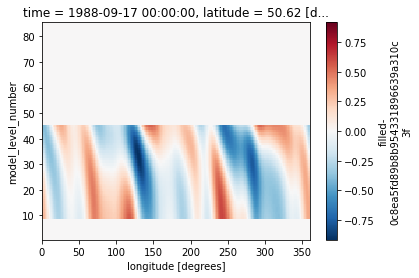

In [24]:
d2.plot()

This is the west phase shift as defined in the code, or the following doc: 

I've been looking at the code for the SPT forcing pattern, with a view to using this pattern or generating my own for a stochastic version of our MCS scheme. I have outputted the diagnostic 35:23 (instantaneous at 0000Z for one month in an N96 simulation) to look at the pattern. I was surprised to see a zonal phase shift with height, whereby the higher you go, the more the pattern phase is displaced to the west. Looking at the code, I think this comes from for_pattern.F90:465-8, where the height-dependent kr var multiplies a phase shift field.

I was interested where this came from, so I had a look at UMDP081. In Sect. 5, just after Eq. 23, it references 

    "Two forcing FΨ patterns are used, the first one is employed to force slow physics tendencies (radiation, micro-
    physics and gravity-wave drag), the forcing pattern has the same vertical distribution as SKEB2’s forcing pattern."

But then I can't see any mention of this in the SKEB2 section.

Digging into the refs, I couldn't find mention of it in Shutts 2005 or Berner et al. 2009 (I may have missed them), but it is described in your paper (Tennant et al., 2010) on p1194. I was thinking that it would be quite useful to put in a small description in the UMDP

In [25]:
d = spt_pattern.isel(model_level_number=10)
vals = d.values.flatten()

In [26]:
vals

array([ 0.3305664 ,  0.33007812,  0.32958984, ..., -0.18188477,
       -0.18261719, -0.18334961], dtype=float32)

In [27]:
vals.shape

(1658880,)

In [28]:
np.percentile(vals, np.arange(0, 101, 10))

array([-1.41723633, -0.34350586, -0.22412109, -0.13964844, -0.06713867,
        0.        ,  0.06762695,  0.140625  ,  0.22558594,  0.34326172,
        1.26049805])

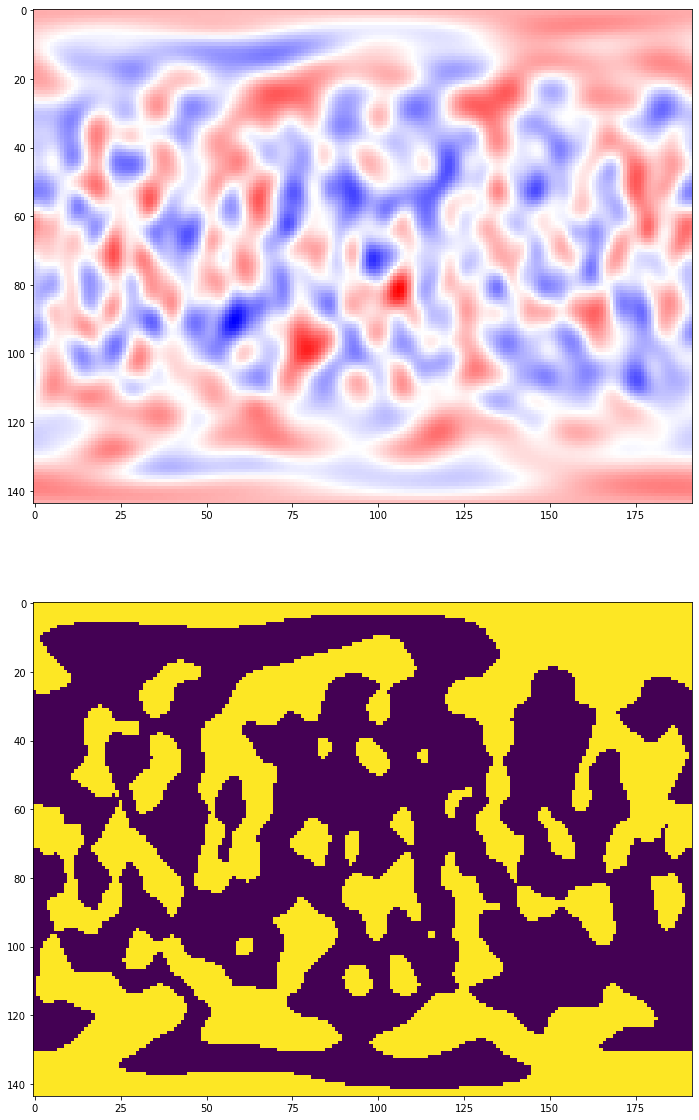

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(20, 20)
ax1.imshow(d[0], cmap='bwr')
ax2.imshow(d[0] > 0.07)

In [30]:
mu, std = norm.fit(vals)

In [31]:
mu, std

(0.00020039361, 0.26962024)

In [37]:
1 / 2**0.5 * np.exp(-1)

0.2601300475114444

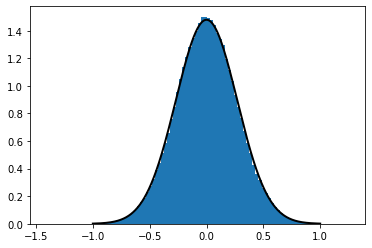

In [32]:
plt.hist(vals, bins=100, density=True)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

In [33]:
norm.cdf(0.07128906, mu, std)

0.6039798886153765

In [34]:
norm.ppf(0.6, mu, std)

0.06850790029325592

In [35]:
norm.cdf(-0.07014466114821678, mu, std)

0.3970831903494861

In [36]:
std

0.26962024